In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode, entropy
from datetime import datetime, timedelta
from collections import defaultdict
import time
import json
import os
from pprint import pprint

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score

#from pyspark import SparkConf, SparkContext
#from pyspark.sql import SQLContext, Row, DataFrameWriter
# from pyspark.ml.classification import LogisticRegression

pd.set_option('display.max_columns', None)
os.chdir('/Users/meif/Desktop/SI 699')
import matplotlib.pyplot as plt

% matplotlib inline 

## 0. Prepare Dataset

In [2]:
# continuous and categorical
mains = ["user_coupon", "user_id", "coupon_id", "start_time", "is_used"]

categorical = ['sex_1', 'sex_2', 
               'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 
               'city1', 'city2', 'city3', 'city4', 'city5', 
               'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8',
               'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 
               'type1', 'type6', 
               'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 
               'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', 
               '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀',
               'CoupUseLast']

conitnuous = ['kitchen_entropy', 
              'distance_median', 'distance_std',
              'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 
              'coupon_effective_days', 'money', 'max_money', 
              'WeeklyCouponUsedCount', "BiWeeklyCouponUsedCount",
              'WeeklyOrderCount', 'BiWeeklyOrderCount',
              'coupon_usage_rate', 'order_coupon_usage_rate',
              'coupon_type1_usage_rate', 'coupon_type6_usage_rate',
              'coupon_used_weekend_perc', 'order_weekend_perc', 
              'worth_money_median', 'worth_money_std', 
              'InterCoup', 'InterOrder', 'Recency']

# take_log= ['Recency_log', 'InterCoup_log', 'InterOrder_log']

In [3]:
trainset = pd.read_csv("Dataset/trainset_180314.csv").iloc[:,1:]
testset = pd.read_csv("Dataset/testset_180314.csv").iloc[:,1:]
print(len(trainset) + len(testset))
print(trainset.columns[5:].tolist())

5484528
['sex_1', 'sex_2', 'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 'city1', 'city2', 'city3', 'city4', 'city5', 'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8', 'kitchen_entropy', 'distance_median', 'distance_std', 'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 'coupon_effective_days', 'money', 'max_money', 'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 'type1', 'type6', 'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀', 'coupon_usage_rate', 'order_coupon_usage_rate', 'coupon_type1_usage_rate', 'coupon_type6_usage_rate', 'coupon_used_weekend_perc', 'order_weekend_perc', 'worth_money_media

In [6]:
# initialization: CV, SCALER, PENALTY, N_JOBS
CV = "3" # 3
if CV == "1":
    cv = [0]
elif CV == "2":
    cv = [3]
elif CV == "3":
    cv = [0,1,2,3]

SCALER = "1" # 1
if SCALER == "1":
    scaler = MinMaxScaler()
elif SCALER == "2":
    scaler = StandardScaler()
elif SCALER == "3":
    scaler = MaxAbsScaler()
elif SCALER == "4":
    scaler = RobustScaler()
    
PENALTY = "l1" # l1
if PENALTY == "l1":
    SOLVER = "saga"
    MAX_ITER = 1000
    C = [0.01, 0.05, 0.1, 0.5, 1]
else:
    SOLVER = "sag"
    MAX_ITER = 500
    C = [0.01, 0.1, 1, 10, 100]

BALANCE = int("2") # 2
N_JOBS = int("4") # 4

RANDOM_STATE = 42

In [7]:
# scaling
X_train_continuous = scaler.fit_transform(trainset[conitnuous])
X_test_continuous = scaler.transform(testset[conitnuous])

trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = conitnuous)], axis=1)
testset_scaled = pd.concat([testset.loc[:,mains + categorical], pd.DataFrame(X_test_continuous, columns = conitnuous)], axis=1)

In [6]:
# split train & dev -- Time Series
split_date1 = "2016-04-15"
split_date2 = "2016-04-22"
split_date3 = "2016-04-29"
split_date4 = "2016-05-06"

trainset1 = trainset_scaled[trainset_scaled["start_time"] <= split_date1]
devset1 = trainset_scaled[(trainset_scaled["start_time"] > split_date1) & (trainset_scaled["start_time"] <= split_date2)]

trainset2 = trainset_scaled[trainset_scaled["start_time"] <= split_date2]
devset2 = trainset_scaled[(trainset_scaled["start_time"] > split_date2) & (trainset_scaled["start_time"] <= split_date3)]

trainset3 = trainset_scaled[trainset_scaled["start_time"] <= split_date3]
devset3 = trainset_scaled[(trainset_scaled["start_time"] > split_date3) & (trainset_scaled["start_time"] <= split_date4)]

trainset4 = trainset_scaled[trainset_scaled["start_time"] <= split_date4]
devset4 = trainset_scaled[trainset_scaled["start_time"] > split_date4]

In [7]:
# shuffle trainset
trainset1 = trainset1.iloc[shuffle(trainset1.index).tolist(),]
trainset2 = trainset2.iloc[shuffle(trainset2.index).tolist(),]
trainset3 = trainset3.iloc[shuffle(trainset3.index).tolist(),]
trainset4 = trainset4.iloc[shuffle(trainset4.index).tolist(),]

In [8]:
trainsets = [trainset1, trainset2, trainset3, trainset4]
devsets = [devset1, devset2, devset3, devset4]

X_trains, y_trains, X_devs, y_devs = [], [], [], []
for i in trainsets:
    X_trains.append(i.iloc[:,5:])
    y_trains.append(i["is_used"])
for i in devsets:
    X_devs.append(i.iloc[:,5:])
    y_devs.append(i["is_used"])

In [8]:
trainset_all = trainset_scaled
trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]
X_train_all = trainset_all.iloc[:,5:]
y_train_all = trainset_all["is_used"]

X_test = testset_scaled.iloc[:,5:]
y_test = testset_scaled["is_used"]

## 1. Logistic Regression

In [9]:
trainset.columns

Index([u'user_coupon', u'user_id', u'coupon_id', u'start_time', u'is_used',
       u'sex_1', u'sex_2', u'age_60', u'age_70', u'age_80', u'age_90',
       u'age_0', u'city1', u'city2', u'city3', u'city4', u'city5',
       u'AppVerLast_2.1', u'AppVerLast_2.2', u'AppVerLast_2.3',
       u'AppVerLast_2.4', u'AppVerLast_2.5', u'AppVerLast_2.7',
       u'AppVerLast_2.8', u'kitchen_entropy', u'distance_median',
       u'distance_std', u'user_longitude_median', u'user_longitude_std',
       u'user_latitude_median', u'user_latitude_std', u'coupon_effective_days',
       u'money', u'max_money', u'covers_mon', u'covers_tue', u'covers_wed',
       u'covers_thu', u'covers_fri', u'covers_sat', u'covers_sun', u'type1',
       u'type6', u'Complaints', u'Eventsoperation',
       u'NewUserCouponPackageByBD', u'PreUserCouponCode', u'RecallUserDaily',
       u'home201603222253', u'home_dongbeiguan', u'home_jiangzhecai',
       u'home_muqinjie', u'home_xiangcaiguan', u'preuser', u'shareuser',
       u'商家拒单

In [4]:
res_lr = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: list)))
res_lr["PENALTY"] = PENALTY
res_lr["SCALER"] = SCALER
res_lr["BALANCE"] = BALANCE

evaluations = ["F05", "Precision", "Recall", "Mean_Pre", "AUC", "Accuracy"]
for c in C:
    for ev in evaluations:
        res_lr[ev][str(c)] = []
res_lr

defaultdict(<function __main__.<lambda>>,
            {'AUC': defaultdict(<function __main__.<lambda>>,
                         {'0.01': [],
                          '0.05': [],
                          '0.1': [],
                          '0.5': [],
                          '1': []}),
             'Accuracy': defaultdict(<function __main__.<lambda>>,
                         {'0.01': [],
                          '0.05': [],
                          '0.1': [],
                          '0.5': [],
                          '1': []}),
             'BALANCE': 2,
             'F05': defaultdict(<function __main__.<lambda>>,
                         {'0.01': [],
                          '0.05': [],
                          '0.1': [],
                          '0.5': [],
                          '1': []}),
             'Mean_Pre': defaultdict(<function __main__.<lambda>>,
                         {'0.01': [],
                          '0.05': [],
                          '0.1': [],

In [ ]:
# train
start_time = time.time()

for c in C:
    start_time2 = time.time()
        
    for n in cv:
        lr = LogisticRegression(C=c, 
                                penalty=PENALTY, solver=SOLVER, 
                                class_weight={1: BALANCE}, 
                                max_iter=MAX_ITER,
                                random_state=RANDOM_STATE, n_jobs=N_JOBS)
        lr.fit(X_trains[n], y_trains[n])
        y_pred = lr.predict(X_devs[n])
        y_dev = y_devs[n]

        print("P: {}, CV: {}, C: {}".format(PENALTY, n, c))
        print(confusion_matrix(y_dev, y_pred, labels=[1,0]))
            
        f05 = fbeta_score(y_dev, y_pred, beta=0.5, labels=[1,0])
        precision = precision_score(y_dev, y_pred, labels=[1,0])
        recall = recall_score(y_dev, y_pred, labels=[1,0])
        mp = average_precision_score(y_dev, y_pred)
        auc = roc_auc_score(y_dev, y_pred)
        acc = accuracy_score(y_dev, y_pred)
        evaluations_res = [f05, precision, recall, mp, auc, acc]
            
        for i in range(len(evaluations)):
            print("{}: {}".format(evaluations[i], evaluations_res[i]))
            res_lr[evaluations[i]][str(c)].append(evaluations_res[i])
        print("\n")
            
    print("Finished c {} in {} sec\n".format(c, time.time() - start_time2))
        
print("{} sec\n".format(time.time() - start_time))

In [16]:
# average cv results
for ev in evaluations:
    res_lr[ev] = {c:np.mean(res_lr[ev][c]) for c in res_lr[ev]}

In [17]:
# save param output
with open('ParamResults/LinearModels/json/res_lr_{}_{}_1v{}.json'.format(PENALTY, SCALER, BALANCE), 'w') as f:
    json.dump(res_lr, f)

# 2. Evaluation

In [ ]:
# load params
res_lr_l1_minmax_1v2 = json.load(open("ParamResults/LinearModels/json/res_lr_l1_1_1v2.json"))
res_lr_l1_maxabs_1v2 = json.load(open("ParamResults/LinearModels/json/res_lr_l1_3_1v2.json"))
res_lr_l2_minmax_1v2 = json.load(open("ParamResults/LinearModels/json/res_lr_l2_1_1v2.json"))
res_lr_l2_maxabs_1v2 = json.load(open("ParamResults/LinearModels/json/res_lr_l2_3_1v2.json"))
res_svm_linear_minmax_1v2 = json.load(open("ParamResults/LinearModels/json/res_svm_linear_1_1v2.json"))
res_svm_linear_stdard_1v2 = json.load(open("ParamResults/LinearModels/json/res_svm_linear_2_1v2.json"))
res_svm_linear_maxabs_1v2 = json.load(open("ParamResults/LinearModels/json/res_svm_linear_3_1v2.json"))
res_svm_linear_minmax_1v9 = json.load(open("ParamResults/LinearModels/json/res_svm_linear_1_1v9.json"))
res_svm_linear_maxabs_1v9 = json.load(open("ParamResults/LinearModels/json/res_svm_linear_3_1v9.json"))
# pprint(res_lr_l2_minmax_1v2)

evaluations = ["F05", "Precision", "Recall", "Mean_Pre", "AUC", "Accuracy"]
l1_c = ["0.01", "0.05", "0.1", "0.5", "1"]
l2_c = ["0.01", "0.1", "1", "10", "100"]
svm_c = ["0.01", "0.1", "1", "10", "100"]

plot_lr_l1_minmax_1v2 = {ev: [res_lr_l1_minmax_1v2[ev][c] for c in l1_c] for ev in evaluations}
plot_lr_l1_maxabs_1v2 = {ev: [res_lr_l1_maxabs_1v2[ev][c] for c in l1_c] for ev in evaluations}

plot_lr_l2_minmax_1v2 = {ev: [res_lr_l2_minmax_1v2[ev][c] for c in l2_c] for ev in evaluations}
plot_lr_l2_maxabs_1v2 = {ev: [res_lr_l2_maxabs_1v2[ev][c] for c in l2_c] for ev in evaluations}

plot_svm_linear_minmax_1v2 = {ev: [res_svm_linear_minmax_1v2[ev][c]["0"] for c in svm_c] for ev in evaluations}
plot_svm_linear_stdard_1v2 = {ev: [res_svm_linear_stdard_1v2[ev][c]["0"] for c in svm_c] for ev in evaluations}
plot_svm_linear_maxabs_1v2 = {ev: [res_svm_linear_maxabs_1v2[ev][c]["0"] for c in svm_c] for ev in evaluations}

plot_svm_linear_minmax_1v9 = {ev: [res_svm_linear_minmax_1v9[ev][c]["0"] for c in svm_c] for ev in evaluations}
plot_svm_linear_maxabs_1v9 = {ev: [res_svm_linear_maxabs_1v9[ev][c]["0"] for c in svm_c] for ev in evaluations}

/Users/meif/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


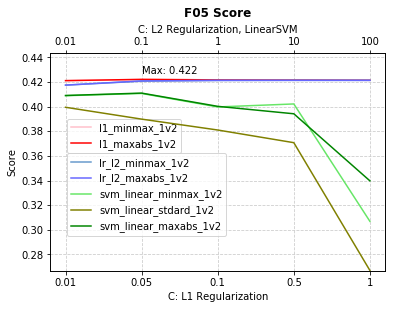

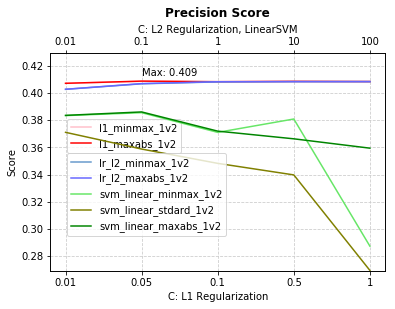

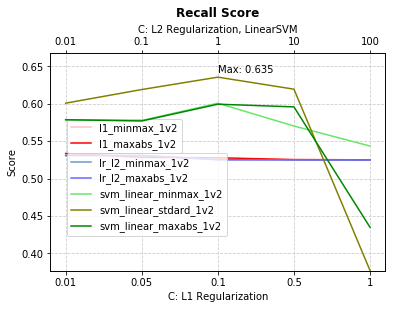

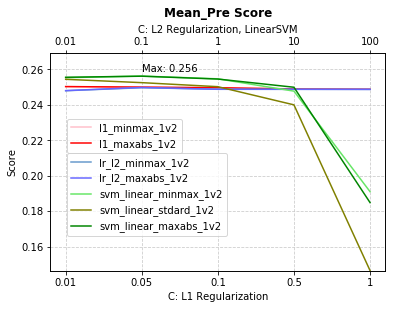

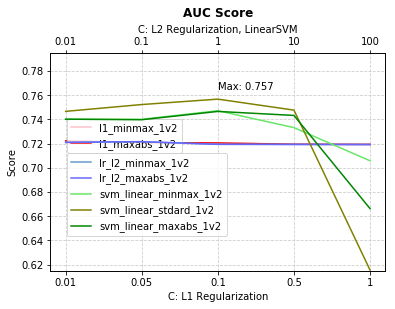

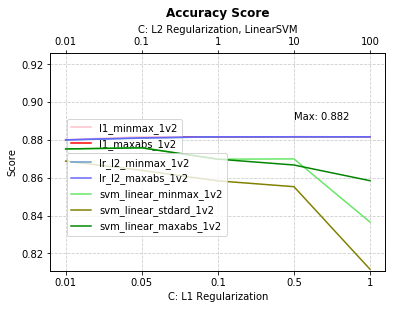

In [19]:
# plot
for i in range(len(evaluations)):
    fig = plt.figure(i + 1)
    
    plt.title(evaluations[i] + " Score", y=1.14, fontweight="bold")
    plt.grid(True, linestyle='--', color='#CCCCCC')
    
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    
    ax1_1 = plot_lr_l1_minmax_1v2[evaluations[i]]
    ax1_2 = plot_lr_l1_maxabs_1v2[evaluations[i]]
    ax2_1 = plot_lr_l2_minmax_1v2[evaluations[i]]
    ax2_2 = plot_lr_l2_maxabs_1v2[evaluations[i]]
    ax2_3 = plot_svm_linear_minmax_1v2[evaluations[i]]
    ax2_4 = plot_svm_linear_stdard_1v2[evaluations[i]]
    ax2_5 = plot_svm_linear_maxabs_1v2[evaluations[i]]
#     ax2_6 = plot_svm_linear_minmax_1v9[evaluations[i]]
#     ax2_7 = plot_svm_linear_maxabs_1v9[evaluations[i]]
    maxIdx = np.argmax(np.array(ax1_1+ax1_2+ax2_1+ax2_2+ax2_3+ax2_4+ax2_5))
    maxScore = max(ax1_1+ax1_2+ax2_1+ax2_2+ax2_3+ax2_4+ax2_5)
    minScore = min(ax1_1+ax1_2+ax2_1+ax2_2+ax2_3+ax2_4+ax2_5)
    
    ax1.set_ylabel('Score')
    ax1.set_xlabel('C: L1 Regularization')
    ax1.set_ylim(minScore*0.999, maxScore*1.05)
    ax1.set_xticks(range(5))
    ax1.set_xticklabels(l1_c)
    ax1.plot(ax1_1, label="l1_minmax_1v2", color='pink')
    ax1.plot(ax1_2, label="l1_maxabs_1v2", color='red')
    ax1.legend(bbox_to_anchor=(0.05, 0.7), loc=2, borderaxespad=0.)

    ax2.set_xlabel('C: L2 Regularization, LinearSVM')
    ax2.set_xticks(range(5))
    ax2.set_xticklabels(l2_c)
    ax2.plot(ax2_1, label="lr_l2_minmax_1v2", color='#6699CC')
    ax2.plot(ax2_2, label="lr_l2_maxabs_1v2", color='#6666FF')
    ax2.plot(ax2_3, label="svm_linear_minmax_1v2", color='#67E667')
    ax2.plot(ax2_4, label="svm_linear_stdard_1v2", color='olive')
    ax2.plot(ax2_5, label="svm_linear_maxabs_1v2", color='#008500')
#     ax2.plot(ax2_6, label="svm_linear_minmax_1v9", color='#67E667')
#     ax2.plot(ax2_7, label="svm_linear_maxabs_1v9", color='#008500')
    ax2.legend(bbox_to_anchor=(0.05, 0.54), loc=2, borderaxespad=0.)

    plt.text(maxIdx%5, 
             maxScore*1.01, 
             'Max: {0:.3f}'.format(maxScore))
    
#     plt.savefig('ParamResults/LinearModels/plots/LinearModels_{}.png'.format(evaluations[i]))
    plt.show()

In [12]:
# retrain using selected params -- l2
c, p, s, b, mi, rs, nj = 0.1, 'l2', 'sag', 2, 1000, 42, 4
lr2_best = LogisticRegression(C=c,
                             penalty=p, solver=s, 
                             class_weight={1: b}, 
                             max_iter=mi,
                             random_state=rs, n_jobs=nj)
lr2_best.fit(X_train_all, y_train_all)

LogisticRegression(C=0.1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=42, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
import pickle
pickle.dump(lr2_best, open('feature_selection_lr2_best.sav', 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

In [8]:
# attributes
lr2_best.coef_

array([[ 2.12840823e-01,  1.38047879e-01, -3.93214143e-02,
        -3.08680065e-03, -4.82779234e-02, -1.52106599e-01,
        -3.43727249e-01,  5.40317646e+00,  5.66036649e+00,
         5.45203727e+00,  5.57676762e+00,  5.56079237e+00,
         1.28460338e+00, -1.88775695e-02,  1.83506561e-01,
         1.19902308e-01,  7.05830411e-03, -1.75702718e-01,
         1.62536665e-01,  6.49621307e-01,  2.59687959e-01,
         5.55818417e-01,  4.79483549e-01,  3.38397357e-01,
         2.79297870e-01,  6.10315783e-01,  1.42351922e+00,
         1.77164991e+00, -7.35623988e-01,  0.00000000e+00,
         0.00000000e+00, -2.10023055e-01, -1.20792762e+00,
        -5.58817670e+00, -5.03573685e+00, -6.10280895e+00,
        -3.71507521e+00,  0.00000000e+00, -9.52332649e-01,
        -2.12249508e+00,  6.13190590e-01, -4.35014409e+00,
        -2.00641005e+00, -1.34466892e+00, -4.83402363e+00,
         1.68599027e-02,  8.51671773e-02, -2.60646083e-01,
        -1.39796362e+00,  8.39112353e-01, -8.95595853e-0

In [13]:
# predict
y_pred = lr2_best.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred)))
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

[[108936  58019]
 [146236 748807]]
F05: 0.4586226669125318
Precision: 0.4269120436411519
Recall: 0.6524871971489323
Mean_Pre: 0.33318657241152394
AUC: 0.7445514340639343
Accuracy: 0.8076691293203943


In [24]:
# retrain using selected params -- l1
c, p, s, b, mi, rs, nj = 0.1, 'l1', 'saga', 3, 1000, 42, 4
lr1_best = LogisticRegression(C=c,
                              penalty=p, solver=s, 
                              class_weight={1: b}, 
                              max_iter=mi,
                              random_state=rs, n_jobs=nj)
lr1_best.fit(X_train_all, y_train_all)

LogisticRegression(C=0.1, class_weight={1: 3}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=42, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
import pickle
pickle.dump(lr1_best, open('feature_selection_lr1_best.sav', 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

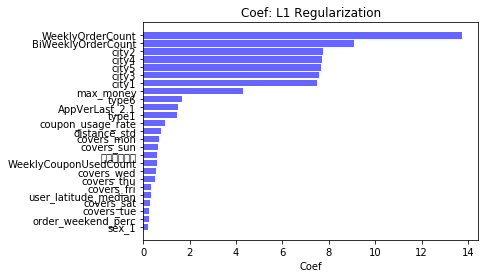

L1 set 0: Index(['age_70', 'AppVerLast_2.2', 'AppVerLast_2.8', 'Eventsoperation',
       'NewUserCouponPackageByBD', 'home_xiangcaiguan', 'user_longitude_std'],
      dtype='object')


In [23]:
# attributes
k = 25
features = X_train_all.columns
coefs = lr1_best.coef_[0]
indices = np.argsort(coefs)
    
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_title('Coef: L1 Regularization')
ax.barh(range(k), coefs[indices[-k:]], color='#6666FF', align='center')
ax.set_yticks(range(k))
ax.set_yticklabels(features[indices[-k:]])
ax.set_xlabel('Coef')
plt.savefig('ParamResults/LinearModels/other/selected_linear_l1.png'.format(s))
plt.show()

print("L1 set 0: {}".format(features[coefs == 0]))

In [21]:
# predict -- 1:2
y_pred = lr1_best.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred)))
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

[[ 68431  98524]
 [ 76848 818195]]
F05: 0.4573830558864065
Precision: 0.47103160126377525
Recall: 0.40987691294061274
Mean_Pre: 0.28583728139616804
AUC: 0.6620086754430261
Accuracy: 0.8348659790319756


In [23]:
# predict -- 1:1
y_pred = lr1_best.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=[1,0]))
print("F05: {}".format(fbeta_score(y_test, y_pred, beta=0.5, labels=[1,0])))
print("Precision: {}".format(precision_score(y_test, y_pred, labels=[1,0])))
print("Recall: {}".format(recall_score(y_test, y_pred, labels=[1,0])))
print("Mean_Pre: {}".format(average_precision_score(y_test, y_pred)))
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

[[ 68431  98524]
 [ 76848 818195]]
F05: 0.4573830558864065
Precision: 0.47103160126377525
Recall: 0.40987691294061274
Mean_Pre: 0.28583728139616804
AUC: 0.6620086754430261
Accuracy: 0.8348659790319756
